# Hackathon Big Data

O primeiro desafio consiste em um cenário de previsão, onde o objetivo será prever o faturamento de cada uma das franquias de uma rede de lojas, onde as franquias estão espalhadas em todo o Brasil.

O segundo desafio consiste em um cenário de expansão, onde o objetivo será prever o faturamento que uma loja teria caso ela existisse em uma região que a franquia ainda não atua.

Este tipo de problema é muito importante para uma rede de franquias existente. A previsão do faturamento é importante para que a franquia possa ter uma estimativa da quantia que ela terá disponível para realizar investimentos e expansão das lojas. A previsão do faturamento em regiões que a loja não atua é importante para que a franquia possa realizar uma expansão mirando as regiões em que ela teria o maior faturamento possível.

# Desafio

**1. Prever o faturamento de lojas existentes na base de dados**

* Neste desafio as equipes deverão prever a média do faturamento mensal dos primeiros três meses de 2018 de cada loja presente na base de dados disponibilizada.

**2. Projetar o faturamento de novas lojas**

* Neste desafio as equipes deverão prever a média do faturamento mensal dos primeiros três meses de 2018 caso a loja existisse em uma região especificada.

O _notebook_ a seguir é estruturado da seguinte forma:

* 1. Imports
* 2. Descrição dos Dados
* 3. Feature Engineering
* 4. Análise de Dados Exploratória
* 5. Preparação dos dados
* 6. Seleção de _Features_
* 7. Modelagem de _Machine Learning_
* 8. Aprimoramento de _Hyperparameters_
* 9. Interpretação dos Resultados

# 1. Coleta de dados

## 1.1. Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import pickle
import requests
from tqdm import tqdm

## 1.2. Funções Auxiliares

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 30]
    plt.rcParams['font.size'] = 20
    plt.rcParams["axes.labelsize"] = 30
    
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    pd.options.display.float_format = '{:,.2f}'.format
    
    sns.set(font_scale = 1.5)
    
def calc_offset_date(df, ano, mes, min_ano = None, min_mes = None):
    '''
    Retorna o valor de offset_date
    '''
    
    if not min_ano:
        min_ano = df['ano'].min()
    
    if not min_mes:
        min_mes = df[df['ano'] == min_ano]['mes'].min()
        
    offset_date = (ano - min_ano) * (12) + mes - min_mes
    
    return offset_date

def get_offset_date(df):
    '''
    Coleta o vetor de offset_date
    '''   
        
    min_ano = df['ano'].min()
    min_mes = df[df['ano'] == min_ano]['mes'].min()
    
    offset_date_list = []
    
    for i in tqdm(range(len(df))):
        
        row = df.loc[i]
        offset_date = calc_offset_date(df, row['ano'], row['mes'], min_ano, min_mes)
        offset_date_list.append(offset_date)
        
    return offset_date_list

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 1.3. Carregando dados

São fornecidos 3 arquivos csv, sendo que o objetivo do problema é predizer a coluna "receita" para o dataset de teste.

* **Arquivos**

    * faturamento_lojas_atuais.csv: Faturamento mensal das lojas, contendo informações dos anos de 2016 e 2017

    * lojas_atuais.csv: Não iremos disponibilizar uma descrição das variáveis presentes neste arquivo. Elas representam as características das lojas, como a metragem, número de cadeiras, número de funcionários, etc. Este arquivo também contém  informações da localização da loja. As colunas de localização serão o código do município e código da área de ponderação. Estes códigos são os mesmos utilizados pelo IBGE

    * cenarios_exapansao.csv: Dados cadastrais de lojas para serem utilizadas no desafio 2. Este arquivo contém as mesmas informações contidas no arquivo lojas_atuais.csv
    
* **Features**

    * faturamento_lojas_atuais.csv:
        
        * cod_loja - número de identificação da loja, é único para cada loja
        
        * ano - ano de registro da receita
        
        * mes - mes de registro da receita
        
        * categoria (?) - categoria de produto vendido
        
        * qtde (?) - quantidade de produtos da categoria vendidos
        
        * receita - receita para a respectiva categoria de produtos no mês e ano especificados
        
    * lojas_atuais.csv e cenarios_expansao.csv:
        
        * cod_loja - número de identificação da loja, é único para cada loja
        
        * cod_ap - código de área de ponderação, definido pelo IBGE e restringem pequenas áreas dentro de municípios
        
        * cod_municipio - código do município, definido pelo IBGE
        
        * feature_01 a feature_18 - não explicitadas
        
Será elaborada a _dataframe_ **"df_raw"**, oriunda da junção de **"df_faturamento_raw"** e **"df_lojas_raw"**, carregados dos _datasets_ fornecidos. Por consequência, uma mesma loja possuirá várias linhas, representando o faturamento mês a mes.

In [4]:
df_expansao_raw = pd.read_csv("./data/raw/cenarios_expansao.csv")
df_faturamento_raw = pd.read_csv("./data/raw/faturamento_lojas_atuais.csv")
df_lojas_raw = pd.read_csv("./data/raw/lojas_atuais.csv")

# merge
df_raw = pd.merge(df_lojas_raw, df_faturamento_raw, how = 'left', on = 'cod_loja')
df_raw.head()

,cod_loja,cod_ap,cod_municipio,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,ano,mes,categoria,qtde,receita
0,1,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.17,0.17,115.96,2.35,NaN,NaN,nan,nan,nan,nan,nan,nan,2016,1,CATEG_01,301.00,"9,164.86"
1,1,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.17,0.17,115.96,2.35,NaN,NaN,nan,nan,nan,nan,nan,nan,2016,2,CATEG_01,187.00,"8,175.55"
2,1,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.17,0.17,115.96,2.35,NaN,NaN,nan,nan,nan,nan,nan,nan,2016,3,CATEG_01,242.00,"10,521.67"
3,1,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.17,0.17,115.96,2.35,NaN,NaN,nan,nan,nan,nan,nan,nan,2016,4,CATEG_01,104.00,"4,560.91"
4,1,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.17,0.17,115.96,2.35,NaN,NaN,nan,nan,nan,nan,nan,nan,2016,5,CATEG_01,100.00,"4,263.30"


# 2. Descrição dos Dados

Esta seção incluirá os seguintes tópicos:

* Dimensão dos Dados

* Tipo dos Dados

* Verificação de Dados faltantes

* Estatística Descritiva

* Tratamento de Dados faltantes

In [5]:
df1 = df_raw.copy()

In [6]:
df1.columns

Index(['cod_loja', 'cod_ap', 'cod_municipio', 'feature_01', 'feature_02',
       'feature_03', 'feature_04', 'feature_05', 'feature_06', 'feature_07',
       'feature_08', 'feature_09', 'feature_10', 'feature_11', 'feature_12',
       'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17',
       'feature_18', 'ano', 'mes', 'categoria', 'qtde', 'receita'],
      dtype='object')

## 2.1. Dimensão dos Dados

De forma a entender quão grande o _dataset_ de análise é, será analisada a dimensão do _dataframe_ em questão. Verifica-se que há **1003094** linhas e **26** colunas.

In [7]:
print("Número de linhas: {}".format(df1.shape[0]))
print("Número de colunas: {}".format(df1.shape[1]))

Número de linhas: 1003094
Número de colunas: 26


## 2.2. Tipo dos Dados

Em seguida, serão analisados os tipos de dados existentes no _dataset_, de modo a abordar cada um apropriadamente.

In [8]:
df1.dtypes

cod_loja           int64
cod_ap             int64
cod_municipio      int64
feature_01        object
feature_02        object
feature_03          bool
feature_04       float64
feature_05        object
feature_06         int64
feature_07       float64
feature_08       float64
feature_09       float64
feature_10       float64
feature_11        object
feature_12        object
feature_13       float64
feature_14       float64
feature_15       float64
feature_16       float64
feature_17       float64
feature_18       float64
ano                int64
mes                int64
categoria         object
qtde             float64
receita          float64
dtype: object

## 2.3. Verificação dos Dados Faltantes

É necessário verificar dados faltantes pelo fato de os algoritmos de _Machine Learning_ atuais não reconhecerem dados nulos. Assim, para um melhor desempenho do modelo, é essencial avaliá-los.

In [9]:
df1.isna().sum().sort_values(ascending = False)

feature_11       922631
feature_12       922631
feature_15       714038
feature_18       714038
feature_17       714038
feature_16       714038
feature_14       714038
feature_13       714038
feature_01       635785
feature_04            0
feature_03            0
feature_02            0
receita               0
feature_06            0
cod_municipio         0
cod_ap                0
feature_05            0
feature_10            0
feature_07            0
feature_08            0
feature_09            0
qtde                  0
ano                   0
mes                   0
categoria             0
cod_loja              0
dtype: int64

## 2.4. Tratamento de Dados faltantes

<font color='red'>???????????????????</font>

<font color='red'>???????????????????</font>

<font color='red'>POR ENQUANTO TO DROPANDO</font>

<font color='red'>???????????????????</font>

<font color='red'>???????????????????</font>

In [10]:
df1.drop(['feature_01', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18'], 
         inplace = True, axis = 1)

## 2.5. Estatística Descritiva

Para realizar uma estatística descritiva, deve-se separar as variáveis númericas das categoricas, pois cada uma possuirá uma forma diferente de análise.

In [11]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64']).drop(['cod_loja', 'cod_ap', 'cod_municipio', 'ano', 'mes'], axis = 1)
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64'])

### 2.5.1. Variáveis Numéricas

Para as variáveis numéricas, serão realizadas dois tipos de análise:

* Tendência central
    * Média
    * Mediana
    
* Dispersão
    * Desvio Padrão
    * Mínimo
    * Máximo
    * Intervalo
    * Assimetria
    * Curtose

In [12]:
d1 = num_attributes.describe()
d2 = pd.DataFrame({"intervalo" : num_attributes.apply(lambda x: x.max() - x.min())}).T
d3 = pd.DataFrame({"assimetria" : num_attributes.apply(lambda x: x.skew())}).T
d4 = pd.DataFrame({"curtose" : num_attributes.apply(lambda x: x.kurtosis())}).T

m = pd.concat([d1, d2, d3, d4]).T.reset_index()
m

,index,count,mean,std,min,25%,50%,75%,max,intervalo,assimetria,curtose
0,feature_04,"1,003,094.00",34.39,13.78,3.50,25.66,31.92,41.11,117.36,113.86,1.05,2.60
1,feature_06,"1,003,094.00",5.75,4.95,0.00,3.00,4.00,7.00,63.00,63.00,3.80,24.55
2,feature_07,"1,003,094.00",0.17,0.05,0.06,0.14,0.18,0.20,0.41,0.35,0.50,0.97
3,feature_08,"1,003,094.00",0.17,0.05,0.04,0.13,0.17,0.19,0.39,0.35,0.33,0.70
4,feature_09,"1,003,094.00",602.74,"1,383.63",1.44,11.82,56.55,334.70,"5,593.91","5,592.47",2.95,7.56
5,feature_10,"1,003,094.00",3.92,2.64,0.42,2.40,3.16,4.46,31.80,31.38,3.29,19.35
6,qtde,"1,003,094.00",204.39,348.23,0.00,20.00,77.00,249.00,"12,160.00","12,160.00",5.00,47.52
7,receita,"1,003,094.00","9,334.46","23,670.26",0.00,600.54,"2,252.82","7,675.57","975,106.40","975,106.40",7.50,94.52


Observando os dados estatísticos de "receita", tem-se:

* Média = 9334,46; indica a média mensal de receita de todas lojas e todas categorias de produto
* Desvio Padrão (std) = 23670,26; este valor de desvio padrão diz que há valores negativos de receita, considerando a média acima, o que não faz sentido. Em análises bivariadas este parâmetro será mais explorado
* Mínimo (min) = 0; indica que, em determinado mês, alguma categoria de produto não vendeu nenhuma unidade 
* Máximo (max) = 975106,4
* Assimetria = 7,5; indica que os valores de receita possuem uma "cauda" mais longa do lado direito da ordenada, ou, em outras palavras, que os dados estão concentrados mais a esquerda quando comparados com uma distribuição normal
* Curtose = 94,52; indica o "achatamento" da curva, ou seja, a curva de receita é concentrada predominantemente em uma região

### 2.5.2. Atributos categóricos

Para a análise de atributos categóricos, são utilizados _boxplots_, de modo a analisar visualmente a dispersão, posição, simetria e outliers do _dataset_ em relação a receita.

É possível interpretar alguns resultados, como a CATEG_11, que é a categoria de produtos que possui uma maior receita quando comparado com os outros tipos de produto.

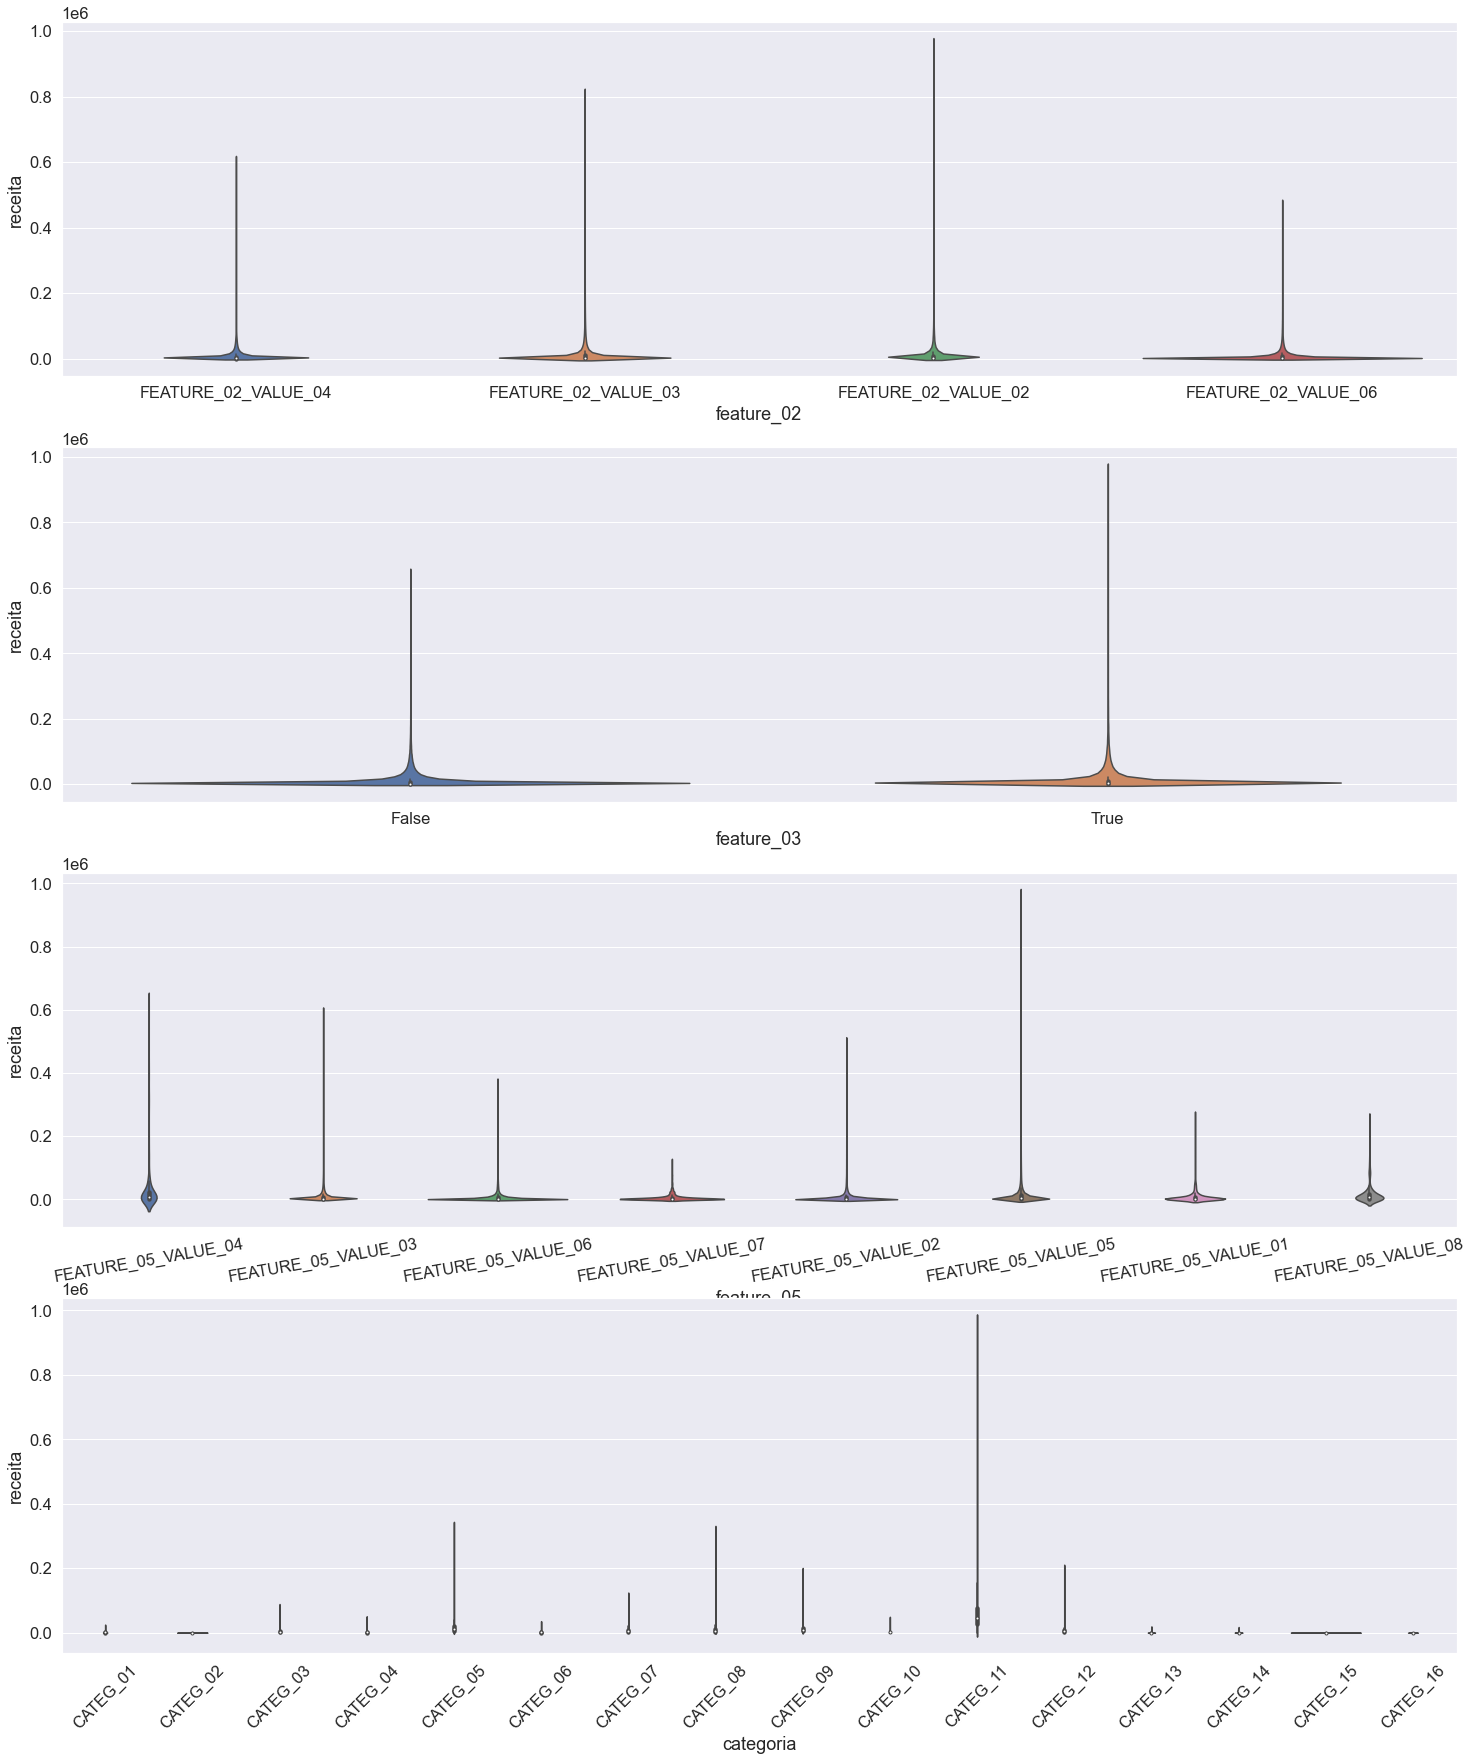

In [13]:
plt.subplot(4,1,1)
_ = sns.violinplot(x = 'feature_02', y = 'receita', data = df1)

plt.subplot(4,1,2)
_ = sns.violinplot(x = 'feature_03', y = 'receita', data = df1)

plt.subplot(4,1,3)
_ = sns.violinplot(x = 'feature_05', y = 'receita', data = df1)
_ = plt.xticks(rotation = 10)

plt.subplot(4,1,4)
_ = sns.violinplot(x = 'categoria', y = 'receita', data = df1)
_ = plt.xticks(rotation = 45)

# 3. Feature Engineering

In [14]:
df2 = df1.copy()

Pelo fato de as _features_ não temporais não serem explicitadas claramente, o processo de _feature engineering_ será baseado unicamente nas variáveis temporais. Criam-se as seguintes varíaveis:

* offset_data - delta de meses após o primeiro registrado
* estado - estado em que se encontra a loja, retirado a partir dos códigos de ponderação e de município 

O código do estado é representado pelos 2 primeiros números de cada código de município. Assim, a partir da tabela a seguir, retirada do próprio IBGE, é possível identificar e classificar o estado de cada região:

**Região Norte**

| Código IBGE |   Estado  | Sigla |
|:-----------:|:---------:|:-----:|
|      11     |  Rondônia |   RO  |
|      12     |    Acre   |   AC  |
|      13     |  Amazonas |   AM  |
|      14     |  Roraima  |   RR  |
|      15     |    Pará   |   PA  |
|      16     |   Amapá   |   AP  |
|      17     | Tocantins |   TO  |

**Região Nordeste**

| Código IBGE |        Estado       | Sigla |
|:-----------:|:-------------------:|:-----:|
|      21     |       Maranhão      |   MA  |
|      22     |        Piauí        |   PI  |
|      23     |        Ceará        |   CE  |
|      24     | Rio Grande do Norte |   RN  |
|      25     |       Paraíba       |   PB  |
|      26     |      Pernambuco     |   PE  |
|      27     |       Alagoas       |   AL  |
|      28     |       Sergipe       |   SE  |
|      29     |        Bahia        |   BA  |

**Região Sudeste**

| Código IBGE |     Estado     | Sigla |
|:-----------:|:--------------:|:-----:|
|      31     |  Minas Gerais  |   MG  |
|      32     | Espírito Santo |   ES  |
|      33     | Rio de Janeiro |   RJ  |
|      35     |    São Paulo   |   SP  |

**Região Sul**

| Código IBGE |       Estado      | Sigla |
|:-----------:|:-----------------:|:-----:|
|      41     |       Paraná      |   PR  |
|      42     |   Santa Catarina  |   SC  |
|      43     | Rio Grande do Sul |   RS  |

**Região Centro-Oeste**

| Código IBGE |       Estado       | Sigla |
|:-----------:|:------------------:|:-----:|
|      50     | Mato Grosso do Sul |   MS  |
|      51     |     Mato Grosso    |   MT  |
|      52     |        Goiás       |   GO  |
|      53     |  Distrito Federal  |   DF  |

<font color='red'>O QUE FAZER COM OS CÓDIGOS -1</font>

In [15]:
# verificando estados únicos
cod_estado = df2['cod_municipio'].astype('str').str[:2]
cod_estado.unique()

array(['41', '53', '35', '31', '16', '11', '27', '29', '26', '25', '33',
       '32', '14', '43', '22', '23', '52', '51', '50', '17', '42', '13',
       '28', '-1', '15', '24', '12', '21'], dtype=object)

In [16]:
# PROBLEMA AQUI
len(df2[df2['cod_municipio'] == -1])/len(df2)

0.04777219283536737

In [17]:
# offset_date
df2['offset_date'] = get_offset_date(df2)

# estado
cod_estado = df2['cod_municipio'].astype('str').str[:2]
cod_estado = cod_estado.replace({'11' : 'RO', '12' : 'AC', '13' : 'AM', '14' : 'RR', '15' : 'PA',
                                 '16' : 'AP', '17' : 'TO', '21' : 'MA', '22' : 'PI', '23' : 'CE',
                                 '24' : 'RN', '25' : 'PB', '26' : 'PE', '27' : 'AL', '28' : 'SE',
                                 '29' : 'BA', '31' : 'MG', '32' : 'ES', '33' : 'RJ', '35' : 'SP',
                                 '41' : 'PR', '42' : 'SC', '43' : 'RS', '50' : 'MS', '51' : 'MT',
                                 '52' : 'GO', '53' : 'DF'})
df2['estado'] =  cod_estado

df2.head()

100%|██████████████████████████████████████████████████████████████████████| 1003094/1003094 [02:57<00:00, 5648.11it/s]


,cod_loja,cod_ap,cod_municipio,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,ano,mes,categoria,qtde,receita,offset_date,estado
0,1,4125506005002,4125506,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.17,0.17,115.96,2.35,2016,1,CATEG_01,301.00,"9,164.86",0,PR
1,1,4125506005002,4125506,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.17,0.17,115.96,2.35,2016,2,CATEG_01,187.00,"8,175.55",1,PR
2,1,4125506005002,4125506,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.17,0.17,115.96,2.35,2016,3,CATEG_01,242.00,"10,521.67",2,PR
3,1,4125506005002,4125506,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.17,0.17,115.96,2.35,2016,4,CATEG_01,104.00,"4,560.91",3,PR
4,1,4125506005002,4125506,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.17,0.17,115.96,2.35,2016,5,CATEG_01,100.00,"4,263.30",4,PR


In [18]:
# drop dos códigos de área
df2.drop(['cod_municipio', 'cod_ap'], axis = 1, inplace = True)
df2.head()

,cod_loja,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,ano,mes,categoria,qtde,receita,offset_date,estado
0,1,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.17,0.17,115.96,2.35,2016,1,CATEG_01,301.00,"9,164.86",0,PR
1,1,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.17,0.17,115.96,2.35,2016,2,CATEG_01,187.00,"8,175.55",1,PR
2,1,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.17,0.17,115.96,2.35,2016,3,CATEG_01,242.00,"10,521.67",2,PR
3,1,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.17,0.17,115.96,2.35,2016,4,CATEG_01,104.00,"4,560.91",3,PR
4,1,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.17,0.17,115.96,2.35,2016,5,CATEG_01,100.00,"4,263.30",4,PR


# 4. Análise de Dados Exploratória